In [2]:
import warnings
warnings.filterwarnings('ignore')

#importing Library 
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils



# Importing data

In [3]:
#Acquiring Data
train_path= './train/'
test_path = './test/'

# Reading and preparing images of cat and dog

In [7]:
train_images = [train_path+i for i in os.listdir(train_path)] #Full training Dataset
train_dogs = [train_path+i for i in os.listdir(train_path) if 'dog' in i] #dogs Dataset
train_cats = [train_path+i for i in os.listdir(train_path) if 'cat' in i] #cats Dataset

test_images = [test_path+i for i in os.listdir(test_path)] #Full test Dataset

ROWS = 64
COLS = 64
CHANNELS = 3

#slicing dataset
train_images = train_dogs[:2000] + train_cats[0:2000]
random.shuffle(train_images)
test_images = test_images[:2000]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    return cv2.resize(img,(ROWS,COLS), interpolation= cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count,CHANNELS,ROWS,COLS), dtype = np.uint8)
    
    for i,image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0:
            print('Processed {} of {}' .format(i,count))
    
    return data   

train = prep_data(train_images)
print('*'*40)
test  = prep_data(test_images)
print('*'*40)
print("Train shape: {}" .format(train.shape))
print("Test shape: {}" .format(test.shape))        


Processed 0 of 4000
Processed 250 of 4000
Processed 500 of 4000
Processed 750 of 4000
Processed 1000 of 4000
Processed 1250 of 4000
Processed 1500 of 4000
Processed 1750 of 4000
Processed 2000 of 4000
Processed 2250 of 4000
Processed 2500 of 4000
Processed 2750 of 4000
Processed 3000 of 4000
Processed 3250 of 4000
Processed 3500 of 4000
Processed 3750 of 4000
****************************************
Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
****************************************
Train shape: (4000, 3, 64, 64)
Test shape: (2000, 3, 64, 64)


# Creating Labels

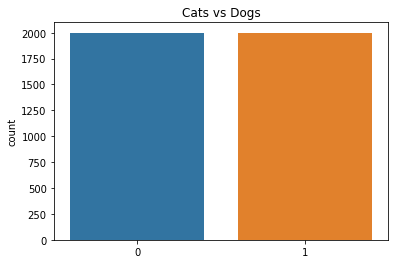

In [8]:
#creating labels

labels = []

for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

#Count plot for cats and dogs

sns.countplot(labels)
plt.title('Cats vs Dogs')
plt.show()
        
        

# Exploring some of the pictures

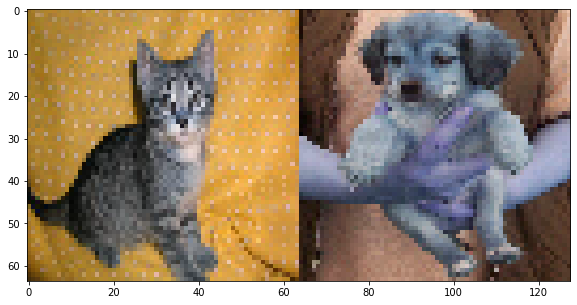

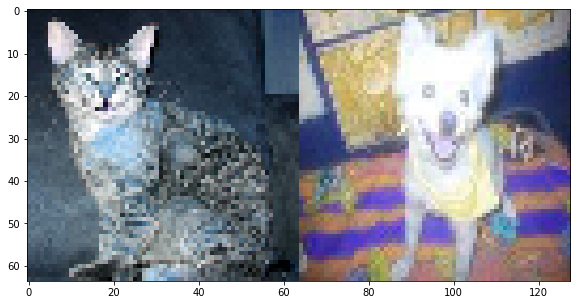

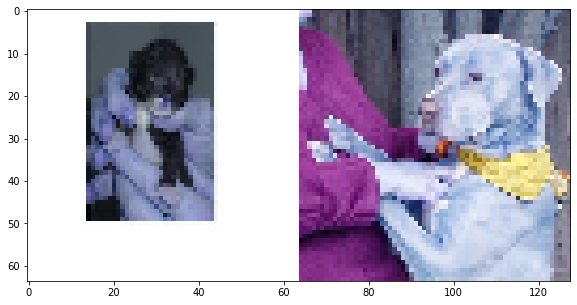

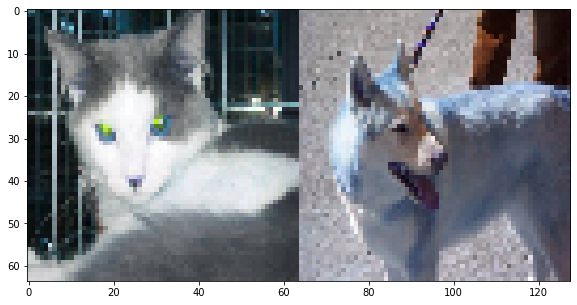

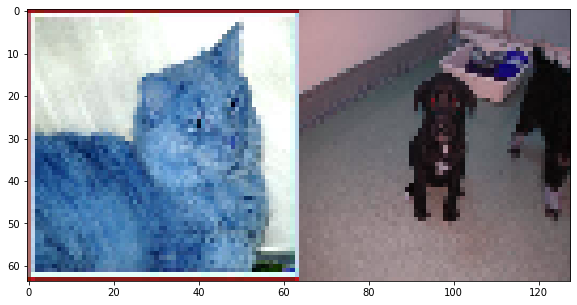

In [9]:
#Checking images of cats and dogs 

def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_cats_and_dogs(idx)

# Training the VGG-16 model

In [10]:
#CatvsDog Model

optimizer = RMSprop(lr = 1e-4)
objective = 'binary_crossentropy'

def CatDog():
    
   
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(3,ROWS, COLS), activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64,(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),dim_ordering="th"))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256,(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model

model= CatDog()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Early stopping callback to end training when the validation loss stops improving

In [11]:

epochs = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

Instructions for updating:
Use tf.cast instead.
Epoch 00004: early stopping


# Visualising loss vs epochs

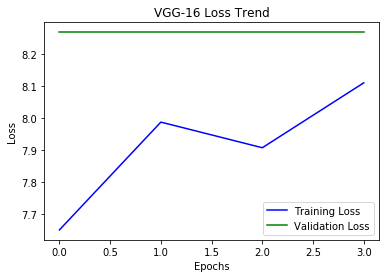

In [14]:
loss = history.losses
val_loss = history.val_losses

#Plotting loss 

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')

plt.legend()
plt.show()

# Predicting Unseen pictures using test data

I am 100.00% sure this is a Cat


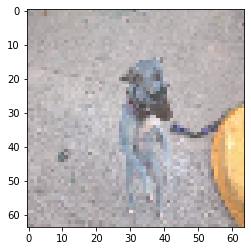

I am 100.00% sure this is a Cat


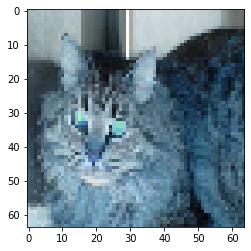

I am 100.00% sure this is a Cat


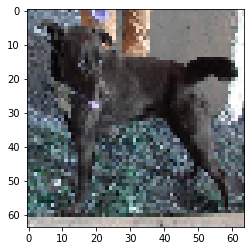

I am 100.00% sure this is a Cat


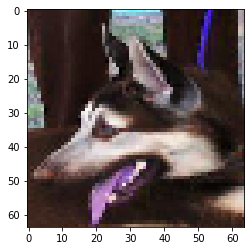

I am 100.00% sure this is a Cat


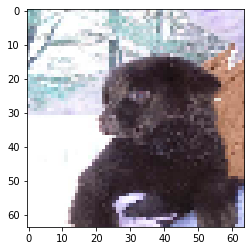

I am 100.00% sure this is a Cat


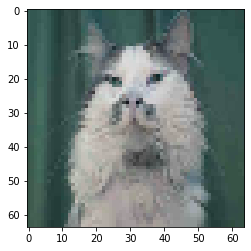

I am 100.00% sure this is a Cat


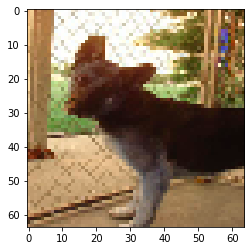

I am 100.00% sure this is a Cat


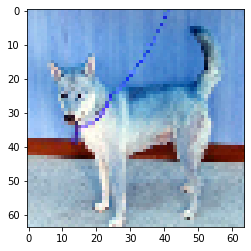

I am 100.00% sure this is a Cat


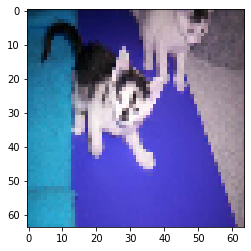

I am 100.00% sure this is a Cat


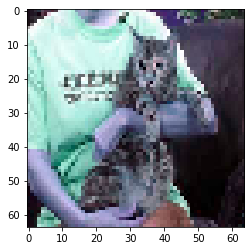

In [15]:
for i in range(10,20):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()